In [8]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import cv2
import math
from tqdm import tqdm
from skimage.transform import resize
from scipy.interpolate import interpn
import pickle as pkl
import time

In [2]:
img = np.rollaxis(np.array(tifffile.imread('Low concentration 1.tiff')), 0, 3)

In [3]:
def preprocess(img, n):
    N = math.floor(0.25 * img.shape[2] / (0.12*n))
    new_img = np.zeros((img.shape[0], img.shape[1], N))
    current = 0
    for k in range(N):
        interp = round(current/0.25)
        new_img[:,:,k] = img[:,:,interp]
        current += 0.12
    
    new_img = resize(new_img, (new_img.shape[0]//n,new_img.shape[1]//n,new_img.shape[2]))
    return new_img
    

In [4]:
img2 = preprocess(img,1)
del img

In [ ]:
for i in range(img2.shape[2]):
    plt.imshow(img2[:,:,i], cmap='gray')
    plt.show()


In [ ]:
plt.imshow(img2[:,:,50], cmap='gray')
plt.show()

In [5]:
def rotation_matrix(a, b, g, x_t, y_t, z_t):
    A = np.array([[np.cos(a)*np.cos(b), np.cos(a)*np.sin(b)*np.sin(g)-np.sin(a)*np.cos(g),np.cos(a)*np.sin(b)*np.cos(g)+np.sin(a)*np.sin(g), x_t],
                  [np.sin(a)*np.cos(b), np.sin(a)*np.sin(b)*np.sin(g)+np.cos(a)*np.cos(g),np.sin(a)*np.sin(b)*np.cos(g)-np.cos(a)*np.sin(g), y_t],
                  [-np.sin(b), np.cos(b)*np.sin(g), np.cos(b)*np.cos(g), z_t],
                  [0, 0, 0, 1]])
    return np.linalg.inv(A)

In [6]:
def rotated_plane(img, a, b, g, x_t, y_t, z_t, interpolation = 'nearest', load = True):
    rot = rotation_matrix(a, b, g, x_t, y_t, z_t)

    count = 0
    p_x, p_y, p_z = img.shape[0]//2, img.shape[1]//2, img.shape[2]//2
    
    if not load:
        indices = np.zeros((4, img.shape[0]*img.shape[1]*img.shape[2]), dtype=np.float16)
        for i in tqdm(range(img.shape[0])):
            for j in range(img.shape[1]):
                for k in range(img.shape[2]):
                    indices[:, count] = [i-p_x, j-p_y, k-p_z, 1]
                    count += 1
        with open('indices.pkl', 'wb') as file:
            pkl.dump(indices, file)
    else:
        with open('indices.pkl', 'rb') as file:
            indices = pkl.load(file)
    indices = rot @ indices
    indices = indices + np.array([[p_x, p_y, p_z, 0]]).T
    del rot 
    indices = indices.T[:, 0:3]
    
    
    return interpn((np.arange(img.shape[0]),np.arange(img.shape[1]),np.arange(img.shape[2])), img, indices, 
    method= interpolation, bounds_error=False, fill_value=0).reshape(img.shape)
                    
                

In [27]:
def single_rotated_plane(img, a, b, g, x_t, y_t, z_t, interpolation = 'nearest', load = True, height = 0):
    rot = rotation_matrix(a, b, g, x_t, y_t, z_t)

    count = 0
    p_x, p_y, p_z = img.shape[0]//2, img.shape[1]//2, img.shape[2]//2
    
    if not load:
        indices = np.zeros((4, img.shape[0]*img.shape[1]), dtype=np.float16)
        for i in tqdm(range(img.shape[0])):
            for j in range(img.shape[1]):
                indices[:, count] = [i-p_x, j-p_y, height-p_z, 1]
                count += 1
        with open('indices.pkl', 'wb') as file:
            pkl.dump(indices, file)
    else:
        with open('indices.pkl', 'rb') as file:
            indices = pkl.load(file)
    indices = rot @ indices
    indices = indices + np.array([[p_x, p_y, p_z, 0]]).T
    indices = indices.T[:, 0:3]
    start_time = time.time()
    A = interpn((np.arange(img.shape[0]),np.arange(img.shape[1]),np.arange(img.shape[2])), img, indices, 
    method= interpolation, bounds_error=False, fill_value=0).reshape(img2.shape[0:2])
    return A, time.time() - start_time

In [37]:
def MIP(img, a, b, g, x_t, y_t, z_t, interpolation = 'nearest'):
    rot = rotation_matrix(a, b, g, x_t, y_t, z_t)
    new_img = np.zeros((img.shape[0], img.shape[1]))
    count = 0
    p_x, p_y, p_z = img.shape[0]//2, img.shape[1]//2, img.shape[2]//2
    
    indices1 = np.zeros((4, img.shape[0]*img.shape[1]), dtype=np.float16)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            indices1[:, count] = [i-p_x, j-p_y, -p_z-1, 1]
            count += 1
    start_time = time.time()
    while True:
        indices1[2,:] += 1
        indices = rot @ indices1
        indices = indices + np.array([[p_x, p_y, p_z, 0]]).T
        indices = indices.T[:, 0:3]
        A = interpn((np.arange(img.shape[0]),np.arange(img.shape[1]),np.arange(img.shape[2])), img, indices, 
        method = interpolation, bounds_error=False, fill_value=0).reshape(new_img.shape)
        if np.max(A) == 0:
            break
        new_img = np.maximum(new_img, A)
    return new_img, time.time() - start_time

def proj_sum(img, a, b, g, x_t, y_t, z_t, interpolation = 'nearest', load = True):
    rot = rotation_matrix(a, b, g, x_t, y_t, z_t)
    new_img = np.zeros((img.shape[0], img.shape[1]))
    count = 0
    p_x, p_y, p_z = img.shape[0]//2, img.shape[1]//2, img.shape[2]//2
    
    indices1 = np.zeros((4, img.shape[0]*img.shape[1]), dtype=np.float16)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            indices1[:, count] = [i-p_x, j-p_y, -p_z-1, 1]
            count += 1
    start_time = time.time()
    while True:
        indices1[2,:] += 1
        indices = rot @ indices1
        indices = indices + np.array([[p_x, p_y, p_z, 0]]).T
        indices = indices.T[:, 0:3]
        A = interpn((np.arange(img.shape[0]),np.arange(img.shape[1]),np.arange(img.shape[2])), img, indices, 
        method = interpolation, bounds_error=False, fill_value=0).reshape(new_img.shape)
        if np.max(A) == 0:
            break
        new_img = np.add(new_img, A)
    return new_img, time.time() - start_time

In [ ]:
new = rotated_plane(img2,math.pi, 0.3, 0.2, 0, 0, 0, 'linear', False)

In [24]:
new = single_rotated_plane(img2,math.pi, 0.3, 0.2, 0, 0, 0, 'linear', False, 25)

100%|██████████| 764/764 [00:00<00:00, 1862.69it/s]


0.1656961441040039


In [25]:
new1 = single_rotated_plane(img2,math.pi, 0.3, 0.2, 0, 0, 0, 'nearest', False, 25)

  0%|          | 0/764 [00:00<?, ?it/s]

100%|██████████| 764/764 [00:00<00:00, 1860.60it/s]

0.052144527435302734


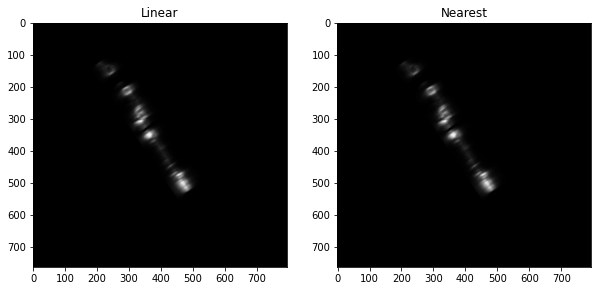

31.63033652305603 2.1374228570256206


In [43]:
times = []

x, y, z = np.random.uniform(-math.pi, math.pi), np.random.uniform(-math.pi, math.pi), np.random.uniform(-math.pi, math.pi)
linear, time1 = MIP(img2,x, y, z, 0, 0, 0, 'linear')
nearest, time2 = MIP(img2,x, y, z, 0, 0, 0, 'nearest')
times.append([time1, time2])
avg = np.mean(times, axis = 0)
avg_diff = np.mean(np.add(avg[0], - avg[1]))
avg_ratio = np.mean(np.divide(avg[0], avg[1]))

fig, ax = plt.subplots(1,2, figsize = (10,10))
ax[0].imshow(linear, cmap='gray')
ax[0].set_title('Linear')
ax[1].imshow(nearest, cmap='gray')
ax[1].set_title('Nearest')
plt.savefig('MIP_lin_near.png')
plt.show()
print(avg_diff, avg_ratio)

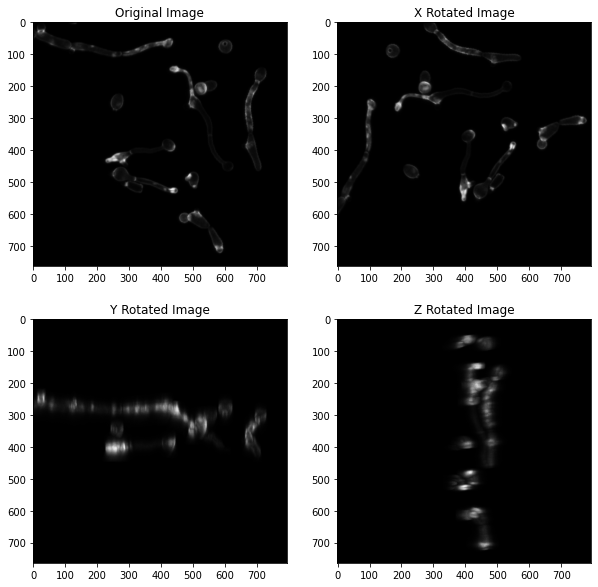

In [42]:
a = 1.25
original_img = MIP(img2,0, 0, 0, 0, 0, 0, 'nearest')[0]
x_rotated_img = MIP(img2,a, 0, 0, 0, 0, 0, 'nearest')[0]
y_rotated_img = MIP(img2,0, a, 0, 0, 0, 0, 'nearest')[0]
z_rotated_img = MIP(img2,0, 0, a, 0, 0, 0, 'nearest')[0]
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0,0].imshow(original_img, cmap='gray')
axs[0,0].set_title('Original Image')
axs[0,1].imshow(x_rotated_img, cmap='gray')
axs[0,1].set_title('X Rotated Image')
axs[1,0].imshow(y_rotated_img, cmap='gray')
axs[1,0].set_title('Y Rotated Image')
axs[1,1].imshow(z_rotated_img, cmap='gray')
axs[1,1].set_title('Z Rotated Image')
plt.savefig('rotated_img.png')
plt.show()

In [41]:
times = []

x, y, z = np.random.uniform(-math.pi, math.pi), np.random.uniform(-math.pi, math.pi), np.random.uniform(-math.pi, math.pi)
linear, time1 = proj_sum(img2,x, y, z, 0, 0, 0, 'linear')
nearest, time2 = proj_sum(img2,x, y, z, 0, 0, 0, 'nearest')
times.append([time1, time2])
avg = np.mean(times, axis = 0)
avg_diff = np.mean(np.add(avg[0], - avg[1]))
avg_ratio = np.mean(np.divide(avg[0], avg[1]))

fig, ax = plt.subplots(1,2, figsize = (10,10))
ax[0].imshow(linear, cmap='gray')
ax[0].set_title('Linear')
ax[1].imshow(nearest, cmap='gray')
ax[1].set_title('Nearest')
plt.show()
plt.savefig('MIP_lin_near.png')
print(avg_diff, avg_ratio)
a = 1.25
original_img = img2[:,:,25]
x_rotated_img = proj_sum(img2,a, 0, 0, 0, 0, 0, 'nearest')[0]
y_rotated_img = proj_sum(img2,0, a, 0, 0, 0, 0, 'nearest')[0]
z_rotated_img = proj_sum(img2,0, 0, a, 0, 0, 0, 'nearest')[0]
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0,0].imshow(original_img, cmap='gray')
axs[0,0].set_title('Original Image')
axs[0,1].imshow(x_rotated_img, cmap='gray')
axs[0,1].set_title('X Rotated Image')
axs[1,0].imshow(y_rotated_img, cmap='gray')
axs[1,0].set_title('Y Rotated Image')
axs[1,1].imshow(z_rotated_img, cmap='gray')
axs[1,1].set_title('Z Rotated Image')
plt.savefig('rotated_img.png')
plt.show()

  0%|          | 0/5 [01:04<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
for i in tqdm(range(40)):
    a = 0.05
    new = MIP(img2,0,0 + a*i, 0, 0, 0, 0, 'linear')
    cv2.imwrite('MIP' + str(i) + '.png', new)

100%|██████████| 40/40 [36:02<00:00, 54.07s/it]


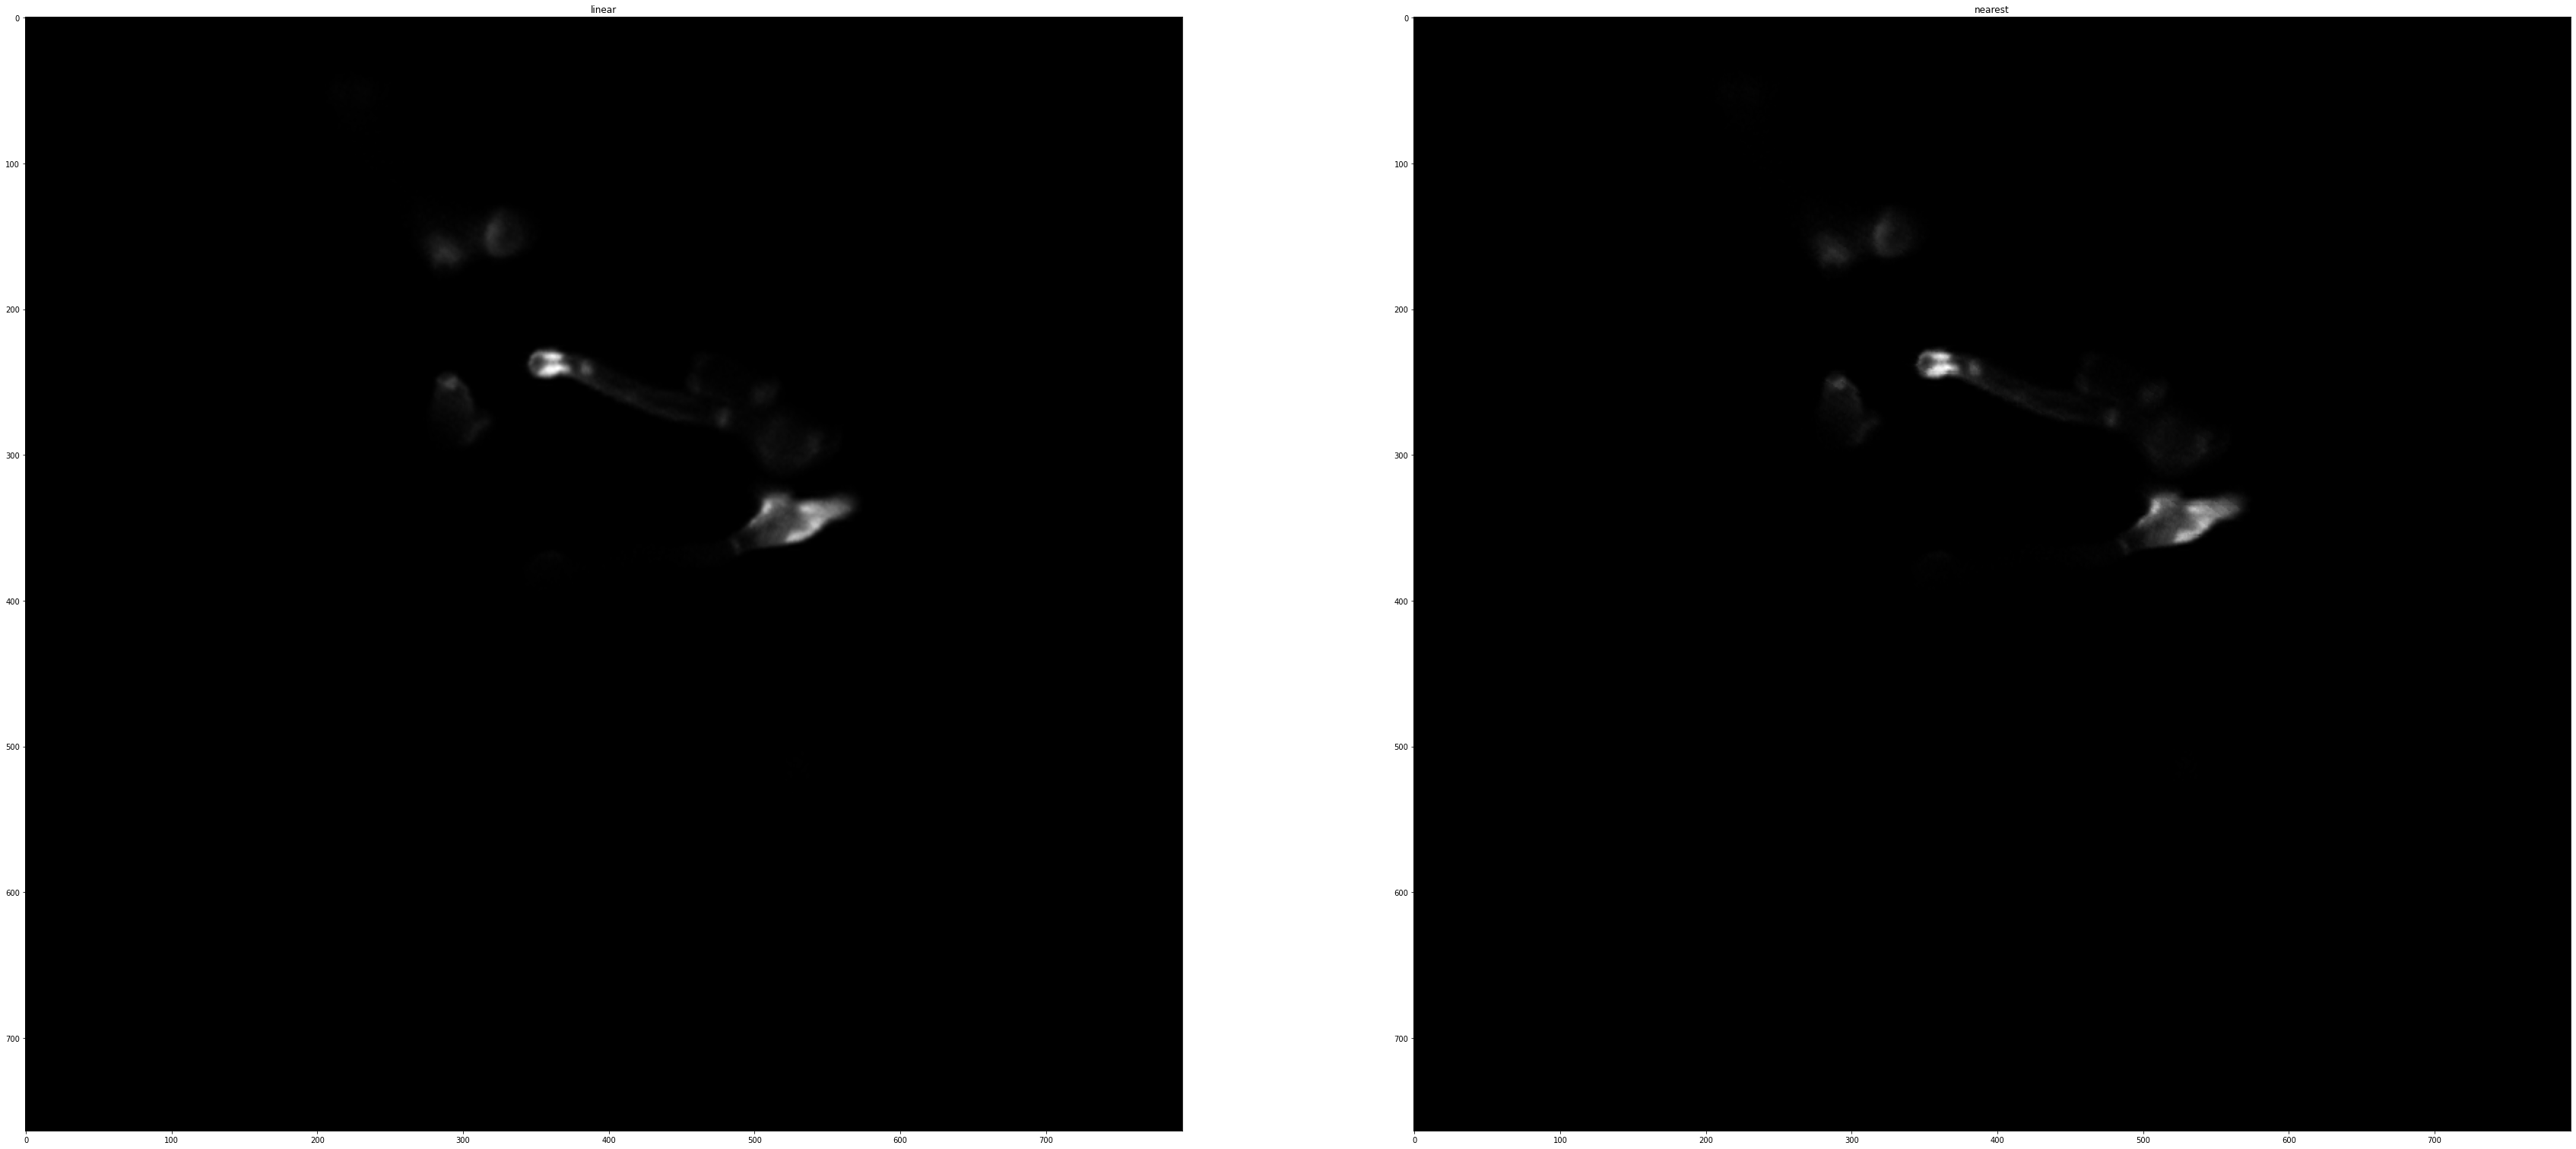

In [23]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(60, 60))
ax1.imshow(new, cmap='gray')
ax1.set_title('linear')
ax2.imshow(new1, cmap='gray')
ax2.set_title('nearest')
plt.savefig('MIP.png')
plt.show()

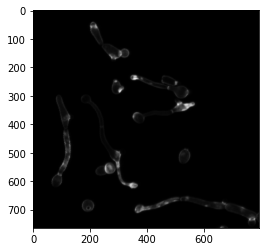

In [15]:
plt.imshow(new[:,:], cmap='gray')

In [9]:
del new

In [10]:
for i in tqdm(range(10)):
    a = 0
    im = MIP(img2, 0, a, 0, 0, 0, 0, 'linear')
    cv2.imwrite('MIP' + str(i) + '.jpg', im)
    a += 2*math.pi/10

 60%|██████    | 6/10 [01:34<01:03, 15.82s/it]


KeyboardInterrupt: 

In [ ]:
rot = rotation_matrix(0, 0, 0, 0, 0, 0)
indexes2 = rot @ indexes
x = np.linspace(0, 120, 120)
y = np.linspace(0, 120, 120)
z = np.linspace(0, 120, 120)
points = (x,y,z)
interpolated = interpn(points, img2, indexes2[:-1,:].T, method='nearest', bounds_error=False, fill_value=1)


In [ ]:
new_img = np.zeros(img2.shape)
counter = 0
for i in tqdm(range(img2.shape[0])):
    for j in range(img2.shape[1]):
        for k in range(img2.shape[2]):
            new_img[i,j,k] = interpolated[counter]
            counter += 1

In [26]:
import glob
import contextlib
from PIL import Image

# filepaths
fp_in = "MIP*.png"
fp_out = "MIP.gif"

# use exit stack to automatically close opened images
with contextlib.ExitStack() as stack:

    # lazily load images
    imgs = (stack.enter_context(Image.open(f))
            for f in sorted(glob.glob(fp_in), key=lambda x: int(x.split('.')[0][3:]) ))

    # extract  first image from iterator
    img = next(imgs)

    # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=200, loop=0)


In [ ]:

plt.imshow(new_img[:,:,100], cmap='gray')
plt.show()

In [ ]:
plt.imshow(img2[:,:,100], cmap='gray')
plt.show()

In [ ]:
print(indexes.shape)
print(indexes2.shape)

In [ ]:
print(img2.shape)